# **Importing or Installing Dependencies**

In [ ]:
import os
from PIL import Image
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torch.nn import CTCLoss
import numpy as np
import matplotlib.pyplot as plt;plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import random
import tarfile
from __future__ import print_function
from __future__ import division
import argparse
import collections
from collections import OrderedDict
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
bleu = sentence_bleu
cc = SmoothingFunction()
import warnings
warnings.filterwarnings('ignore')

device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");print(device_gpu)

cuda:0


In [ ]:
!pip install pytorch-nlp
from torchnlp.metrics import get_moses_multi_bleu as bleu

     |████████████████████████████████| 92kB 4.4MB/s 


In [ ]:
!python --version
!nvcc --version #CUDA > 8.0
!pip install lmdb

Python 3.6.9
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


**Requirements** according to crnn.pytorch github repo

lmdb==0.97
numpy==1.17.2
Pillow==6.1.0
six==1.12.0
torch==1.2.0
torchvision==0.4.0

### Loading CRNN Model from GITHUB

In [ ]:
if not os.getcwd() == '/content':
    os.chdir('/content')
if not os.path.isdir('crnn.pytorch'):
    !git clone https://github.com/meijieru/crnn.pytorch.git

Cloning into 'crnn.pytorch'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (82/82), done.


In [ ]:
#Run this Magic Command before training
#It will not allow disconnection in Google Colab
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,100000)

<IPython.core.display.Javascript object>

# **Hindi Dataset Creation**

In [ ]:
%%time
if not os.path.isdir('/content/SynthCropped'):
    os.mkdir('/content/SynthCropped')
    os.mkdir('/content/SynthCropped/Imgs')

with open('/content/SynthCropped/SynthCropped.txt','a') as f_SynthCropped:
    # folders = [1,4,10,15]
    folders = list(range(1,26))
    full_cnt = 0
    for i in folders:
        cnt = 0
        basepath_Image = '/content/Synth/Image/' + str(i) + '/'
        basepath_Annotation = '/content/Synth/Annotation/' + str(i) + '/'
        output_Ipath = '/content/SynthCropped/Imgs/' + str(i) + '--'
        Ipaths = os.listdir(basepath_Image[:-1])
        Apaths = os.listdir(basepath_Annotation[:-1])
        Ipaths.sort();Apaths.sort()
        for I,A in zip(Ipaths,Apaths):
            if(I.split('.')[0] == A.split('.')[0]):
                with open(basepath_Annotation + A,'r',encoding='utf8') as f:
                    annot_Lines = f.readlines()
                    img = Image.open(basepath_Image + I)
                    for line in annot_Lines:
                        cnt += 1
                        line_split = line.split(' ')
                        aa = [int(float(a)) for a in line_split[:-1]]
                        xmin, xmax = min(aa[:4]),max(aa[:4])
                        ymin, ymax = min(aa[4:]),max(aa[4:])
                        img_crop = img.crop((xmin, ymin, xmax, ymax))
                        cropImage_name = output_Ipath + str(cnt) + '.jpg'
                        img_crop.save(cropImage_name)
                        f_SynthCropped.writelines(cropImage_name + ' ' + line_split[-1])
                        # print(cropImage_name + ' ' + line_split[-1])
        full_cnt += cnt
        print('Folder: %d %d %d' % (i, cnt, full_cnt))



In [ ]:
tarfile_name = "/content/SynthCropped_full.tar.gz"
# tarfile_name = "/content/SynthCropped_1-4-10-15.tar.gz"
tar = tarfile.open(tarfile_name, "w:gz")
os.chdir("/content/SynthCropped")
for name in os.listdir("."):
    tar.add(name)
tar.close()
os.chdir('/content')

In [ ]:
tarfile_name = "/content/saved_models_0.tar.gz"
tar = tarfile.open(tarfile_name, "w:gz")
os.chdir("/content/drive/My Drive/DATASETS/CRNN_currUse/saved_models_0")
for name in os.listdir("."):
    tar.add(name)
tar.close()
os.chdir('/content')

## **Extract Test/Train Data Folders from Google Drive**

In [ ]:
!rm -rf '/content/RecogTestCropped'
!rm -rf '/content/SynthCropped'
!rm -rf '/content/sample_data'
!rm -rf '/content/Synth'

if not os.path.isdir('/content/SynthCropped'):
    os.mkdir('/content/SynthCropped')

if not os.getcwd() == '/content/SynthCropped':
    os.chdir('/content/SynthCropped')

!tar -xvf  '/content/drive/My Drive/DATASETS/SynthCropped_full.tar.gz'

if not os.getcwd() == '/content':
    os.chdir('/content')
    
!tar -xvf  '/content/drive/My Drive/DATASETS/cropped_data.tar'
os.rename('/content/cropped_data', '/content/RecogTestCropped')

Streaming output truncated to the last 5000 lines.
Imgs/23--4263.jpg
Imgs/12--1902.jpg
Imgs/12--19715.jpg
Imgs/3--12132.jpg
Imgs/5--9858.jpg
Imgs/4--1292.jpg
Imgs/23--24834.jpg
Imgs/19--14245.jpg
Imgs/24--17043.jpg
Imgs/13--9516.jpg
Imgs/5--21471.jpg
Imgs/17--18736.jpg
Imgs/7--2738.jpg
Imgs/4--8648.jpg
Imgs/15--704.jpg
Imgs/16--9324.jpg
Imgs/22--11840.jpg
Imgs/19--4466.jpg
Imgs/8--18699.jpg
Imgs/7--6566.jpg
Imgs/12--5600.jpg
Imgs/24--24317.jpg
Imgs/3--18134.jpg
Imgs/13--18977.jpg
Imgs/20--29790.jpg
Imgs/17--9668.jpg
Imgs/8--6380.jpg
Imgs/1--13137.jpg
Imgs/9--12139.jpg
Imgs/11--25808.jpg
Imgs/21--1011.jpg
Imgs/4--7618.jpg
Imgs/1--4928.jpg
Imgs/25--4471.jpg
Imgs/18--4203.jpg
Imgs/6--9075.jpg
Imgs/10--20793.jpg
Imgs/8--13532.jpg
Imgs/15--15036.jpg
Imgs/4--14943.jpg
Imgs/2--13129.jpg
Imgs/23--15911.jpg
Imgs/1--25579.jpg
Imgs/10--26.jpg
Imgs/14--9934.jpg
Imgs/7--15655.jpg
Imgs/23--16718.jpg
Imgs/13--882.jpg
Imgs/18--4404.jpg
Imgs/12--14987.jpg
Imgs/23--14665.jpg
Imgs/11--2981.jpg
Imgs/17--2

# **CRNN Model for Text Recognition**

## Helper Functions

In [ ]:

class averager(object):
    def __init__(self):
        self.reset()

    def add(self, v):
        if isinstance(v, Variable):
            count = v.data.numel()
            v = v.data.sum()
        elif isinstance(v, torch.Tensor):
            count = v.numel()
            v = v.sum()
        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)
        return res

class strLabelConverter(object):
    def __init__(self, alphabet, ignore_case = False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'
        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i + 1

    def encode(self, text):
        if isinstance(text, str):
            text = [ self.dict[char.lower() if self._ignore_case else char] for char in text]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [ ]:
def oneHot(v, v_length, nc):
    batchSize = v_length.size(0)
    maxLength = v_length.max()
    v_onehot = torch.FloatTensor(batchSize, maxLength, nc).fill_(0)
    acc = 0
    for i in range(batchSize):
        length = v_length[i]
        label = v[acc:acc + length].view(-1, 1).long()
        v_onehot[i, :length].scatter_(1, label, 1.0)
        acc += length
    return v_onehot

def loadData(v, data):
    with torch.no_grad():
        v.resize_(data.size()).copy_(data)

def prettyPrint(v):
    print('Size {0}, Type: {1}'.format(str(v.size()), v.data.type()))
    print('| Max: %f | Min: %f | Mean: %f' % (v.max().data[0], v.min().data[0],v.mean().data[0]))
    
def assureRatio(img):
    
    b, c, h, w = img.size()
    if h > w:
        main = nn.UpsamplingBilinear2d(size=(h, h), scale_factor=None)
        img = main(img)
    return img

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:

class SynthCrop_HINDI_TEXTRECOG_DataSet(Dataset):
    def __init__(self, dir_path, train=True,transform=None):
        self.transform = transform
        self.annotation_file_path = os.path.join(dir_path,'SynthCropped.txt')
        self.train=train
        self.dataset_annotations = []
        hindi_num_set = set([chr(alpha) for alpha in range(2406, 2416)])
        with open(self.annotation_file_path,'rt') as f_txt:
            textfile_lines = f_txt.readlines()
            for line in textfile_lines:
                line_split = line[:-1].split(' ') #Ignoring '\n' in label
                i_name, l_name = line_split[0],line_split[1]
                if not (set(l_name).intersection(hindi_num_set)):
                    self.dataset_annotations.append((i_name, l_name))
        self.len = len(self.dataset_annotations)

    def __len__(self):
        return len(self.dataset_annotations)
    
    def __getitem__(self, index):
        image_data = self.pil_loader(self.dataset_annotations[index][0])
        if self.transform:
            image_data = self.transform(image_data)
        label_data = self.dataset_annotations[index][1]
        return image_data, label_data

    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

class SynthCrop_HINDI_TEXTRECOG_DataSet_testing(Dataset):
    def __init__(self, dir_path, train=True,transform=None):
        self.transform = transform
        self.dir_path = dir_path
        self.annotation_file_path = os.path.join(self.dir_path,'annotations.txt')
        self.train=train
        self.dataset_annotations = []
        hindi_num_set = set([chr(alpha) for alpha in range(2406, 2416)])
        with open(self.annotation_file_path,'rt') as f_txt:
            textfile_lines = f_txt.readlines()
            for line in textfile_lines:
                line_split = line.split()
                i_name, l_name = line_split[0],line_split[1]
                if not (set(l_name).intersection(hindi_num_set)):
                    self.dataset_annotations.append((i_name, l_name))
        self.len = len(self.dataset_annotations)

    def __len__(self):
        return len(self.dataset_annotations)
    
    def __getitem__(self, index):
        image_data = self.pil_loader(os.path.join(self.dir_path,self.dataset_annotations[index][0]))
        if self.transform:
            image_data = self.transform(image_data)
        label_data = self.dataset_annotations[index][1]
        return image_data, label_data

    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

In [ ]:
def get_mean_std(data_loader):
    ch_sum, ch_sum_sqrd, n_batches = 0.0,0.0,0.0
    for data, _ in tqdm(data_loader) :
        #computing per channel mean/std for each image and adding it up
        ch_sum += torch.mean(data,dim=[0,2,3]) 
        ch_sum_sqrd += torch.mean(data**2, dim=[0,2,3])
        n_batches += 1 
    
    mean = (ch_sum/n_batches)
    std = (ch_sum_sqrd/n_batches - mean**2)**0.5
    return mean,std

#get_mean_std(train_loader)
#Output of this function on train_loader dataset is:
#(tensor([0.4560, 0.4620, 0.4657]), tensor([0.2642, 0.2604, 0.2872]))
#mean per channel - [0.4560, 0.4620, 0.4657] 
#sd per chennal - [0.2642, 0.2604, 0.2872]

## **Model**

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut,dropout = True):
        super(BidirectionalLSTM, self).__init__()
        if dropout:
            self.rnn = nn.LSTM(nIn, nHidden, dropout = 0.2, bidirectional=True)
        else:
            self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden*2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, n_rnn=2):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]
        cnn = nn.Sequential()
    
        def convRelu(i, dropOut = False, batchNormalization=True, leakyRelu = True):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i), nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

            if dropOut:
                cnn.add_module('dropout{0}'.format(i), nn.Dropout(0.2))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6,batchNormalization=False)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh, dropout = True),
            BidirectionalLSTM(nh, nh, nclass, dropout = False) )

    def forward(self, input):
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        # print(b,c,h,w)
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        output = self.rnn(conv)
        return output

## Training & Test Scene Text Recognition Task

### Parsing Argument - Assigning the Settings and Hyperparameters

In [ ]:

parser = argparse.ArgumentParser()
#Creating string of hindi characters (without numbers) using Unicode convention
hindi_alphabets = ''
for alpha in range(2304, 2432):
    if not alpha in range(2406,2416):
        hindi_alphabets += chr(alpha)
parser.add_argument('--alphabet', type=str, default = hindi_alphabets)
parser.add_argument('--split_ratio', type=float, default=0.95, help='Ratio to split train dataset, train:validation = split_ratio')
parser.add_argument('--imgH', type=int, default=32, help='the height of the input image to network')
parser.add_argument('--imgW', type=int, default=100, help='the width of the input image to network')
parser.add_argument('--nh', type=int, default = 512, help='size of the lstm hidden state')
parser.add_argument('--cuda', action='store_false', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--keep_ratio', action='store_true', help='whether to keep ratio for image resize')
parser.add_argument('--manualSeed', type=int, default=1234, help='reproduce experiment')

parser.add_argument('--batch_size', type=int, default=128, help='input batch size')
parser.add_argument('--test_batch_size', type=int, default=8, help='test batch size')
parser.add_argument('--lr', type=float, default=0.005, help='learning rate for Critic, not used by adadealta')
parser.add_argument('--beta1', type=float, default=0.7, help='beta1 for adam. default=0.5')
parser.add_argument('--adam', action='store_true', help='Whether to use adam (default is rmsprop)')
parser.add_argument('--adadelta', action='store_false', help='Whether to use adadelta (default is rmsprop)')
parser.add_argument('--pretrained', default='/content/drive/My Drive/DATASETS/CRNN_currUse/saved_models/netCRNN_14_4983.pth', help="path to pretrained model")
parser.add_argument('--out_dir', default='saved_models', help='Where to store samples and models')
parser.add_argument('--out_gdrive_dir', default='/content/drive/My Drive/DATASETS/CRNN_currUse/saved_models', help='Path to save models to Google Drive')
parser.add_argument('--nepoch', type=int, default=15, help='number of epochs to train for')
parser.add_argument('--val_max_iter', type=int, default=2000, help='Max num of val iterations')
parser.add_argument('--n_test_disp', type=int, default=10, help='Number of samples to display when test')
parser.add_argument('--trainInterval', type=int, default=100, help='Interval to be displayed')
parser.add_argument('--valInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--saveInterval', type=int, default=1000, help='Interval to be displayed')
parser.add_argument('--display_loss', action='store_false', help='Whether to display loss plot or not')
settings = parser.parse_args('')
print(settings,'\n')

#nc - number of input channels, nclass - dictionary size (#num classes)
nclass = len(settings.alphabet) + 1
nc = 3

transform_crnn = transforms.Compose([ transforms.Resize((32,100)),transforms.ToTensor(), transforms.Normalize((0.4560, 0.4620, 0.4657), (0.2642, 0.2604, 0.2872))])
full_data = SynthCrop_HINDI_TEXTRECOG_DataSet('/content/SynthCropped', train = True, transform = transform_crnn)
train_size = int(settings.split_ratio * len(full_data))
val_size = len(full_data) - train_size
train_data, val_data = random_split(full_data, [train_size,val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size = settings.batch_size, num_workers = 2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = settings.batch_size, num_workers = 2, shuffle=True)
test_data = SynthCrop_HINDI_TEXTRECOG_DataSet_testing('/content/RecogTestCropped', train = False, transform = transform_crnn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = settings.test_batch_size, num_workers = 1, shuffle=True)
print("Train (Full) Dataset Size: ", full_data.__len__())
print("Train (Train) Dataset Size: ", train_data.__len__())
print("Train (Validation) Dataset Size: ", val_data.__len__())
print("Test Dataset Size: ", test_data.__len__())
print("Train DataLoader Size: ", len(train_loader))
print("Validation DataLoader Size: ", len(val_loader))
print("Test DataLoader Size: ", len(test_loader))
print("Input Channels: ", nc)
print("Vocabulary Size: ", nclass)
print("Hindi Dictionary: ", settings.alphabet)

if not os.path.exists(settings.out_dir):
    os.makedirs(settings.out_dir)
random.seed(settings.manualSeed)
np.random.seed(settings.manualSeed)
torch.manual_seed(settings.manualSeed)
cudnn.benchmark = True

image = torch.FloatTensor(settings.batch_size, 3, settings.imgH, settings.imgH)
text = torch.IntTensor(settings.batch_size * 5)
length = torch.IntTensor(settings.batch_size)
image = Variable(image)
text = Variable(text)
length = Variable(length)

#Instantiating Model
crnn = CRNN(settings.imgH, nc, nclass, settings.nh)
crnn.apply(weights_init)
if settings.pretrained != '':
    print('Loading PreTrained Model from %s' % settings.pretrained)
    state_dict = torch.load(settings.pretrained)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove "module."
        new_state_dict[name] = v
    crnn.load_state_dict(new_state_dict)

#Utilities
converter = strLabelConverter(settings.alphabet)
criterion = CTCLoss()
loss_avg = averager()
if settings.adam:
    optimizer = optim.AdamW(crnn.parameters(), lr=settings.lr, betas=(settings.beta1, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
elif settings.adadelta:
    optimizer = optim.Adadelta(crnn.parameters())
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=settings.lr)

#CUDA settings
if torch.cuda.is_available() and not settings.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")
if settings.cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(settings.ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

Namespace(adadelta=True, adam=False, alphabet='ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ।॥॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿ', batch_size=128, beta1=0.7, cuda=True, display_loss=True, imgH=32, imgW=100, keep_ratio=False, lr=0.005, manualSeed=1234, n_test_disp=10, nepoch=15, ngpu=1, nh=512, out_dir='saved_models', out_gdrive_dir='/content/drive/My Drive/DATASETS/CRNN_currUse/saved_models', pretrained='/content/drive/My Drive/DATASETS/CRNN_currUse/saved_models/netCRNN_14_4983.pth', saveInterval=1000, split_ratio=0.95, test_batch_size=8, trainInterval=100, valInterval=500, val_max_iter=2000) 

Train (Full) Dataset Size:  671312
Train (Train) Dataset Size:  637746
Train (Validation) Dataset Size:  33566
Test Dataset Size:  1712
Train DataLoader Size:  4983
Validation DataLoader Size:  263
Test DataLoader Size:  214
Input Channels:  3
Vocabulary Size:  119
Hindi Dictionary:  ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊो

### Network Architecture

In [ ]:
print('############### Network Architecture ######################')
print(crnn,'\n')
print('Number of total parameters in CRNN model: %d (%0.2f million)' % (sum(p.numel() for p in crnn.parameters()),sum(p.numel() for p in crnn.parameters())/1000000 ))

############### Network Architecture ######################
DataParallel(
  (module): CRNN(
    (cnn): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
      (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
      (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): LeakyReLU(negative_

### Train Loop

हे----------त------------- => हेत                 , gt: हेतु                
रह------------------------ => रह                  , gt: है                  
गु----------रर------------ => गुर                 , gt: गुर्रा              
से------न-्टट-----र------- => सेन्टर              , gt: सेन्टर              
वव-------व---ररर्--------- => ववर्                , gt: वर्क्स              
आई------------------------ => आई                  , gt: भाई                 
बज----------र----णण------- => बजरण                , gt: बजरंग               
भी------------------------ => भी                  , gt: श्री                
Validation loss: 0.203929, accuray: 0.017961


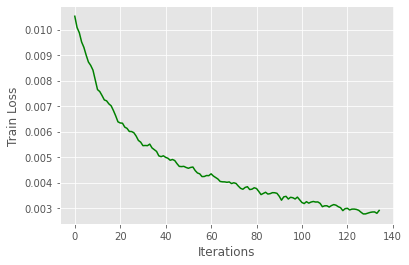

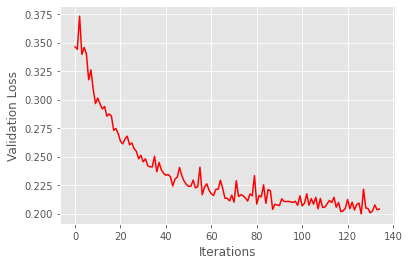

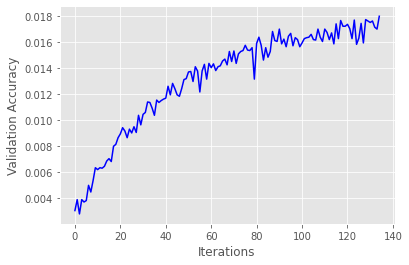

[14/15][4600/4983] Loss: 0.002737
[14/15][4700/4983] Loss: 0.002784
[14/15][4800/4983] Loss: 0.002762
[14/15][4900/4983] Loss: 0.002757


In [ ]:
TRAIN_LOSS_LIST = []
VAL_LOSS_LIST = []
VAL_ACC_LIST = []
min_val_loss = 1000

for epoch in range(settings.nepoch):
    train_iter = iter(train_loader)
    i = 0
    while i < len(train_loader):
        for p in crnn.parameters():
            p.requires_grad = True
        crnn.train()

        cost = trainBatch(crnn, criterion, optimizer)
        loss_avg.add(cost)
        i += 1

        if i % settings.trainInterval == 0:
            print('[%d/%d][%d/%d] Loss: %f' % (epoch, settings.nepoch, i, len(train_loader), loss_avg.val()))

        if i % settings.valInterval == 0:
            clear_output(wait=True)
            TRAIN_LOSS_LIST.append(loss_avg.val())
            loss_avg.reset()
            val_loss,val_acc = val(crnn, test_loader, criterion)
            VAL_LOSS_LIST.append(val_loss)
            VAL_ACC_LIST.append(val_acc)
            if min_val_loss > val_loss:
                min_val_loss = val_loss
            if(settings.display_loss):
                plt.plot(TRAIN_LOSS_LIST,'g',label = 'train_loss');plt.xlabel('Iterations');plt.ylabel('Train Loss');plt.show()
                plt.plot(VAL_LOSS_LIST,'r',label = 'val_loss');plt.xlabel('Iterations');plt.ylabel('Validation Loss');plt.show()
                plt.plot(VAL_ACC_LIST,'b');plt.xlabel('Iterations');plt.ylabel('Validation Accuracy');plt.show()

        # Checkpointing
        if (i % settings.saveInterval == 0) and (min_val_loss > val_loss):
            torch.save(crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(settings.out_dir, epoch, i))
    
    #Early Stopping using Validation Loss trend
    stop_list = VAL_LOSS_LIST[-4:]
    if all(i < j for i, j in zip(stop_list, stop_list[1:])):
        print("EARLY STOPPING HURRAY")
        torch.save(crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(settings.out_dir, epoch, i))
        torch.save(crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(settings.out_gdrive_dir, epoch, i))
        break
            
    torch.save(crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(settings.out_gdrive_dir, epoch, i))

In [ ]:
def val(net, data_loader, criterion, max_iter=settings.val_max_iter):

    print('Start validation')
    for p in crnn.parameters():
        p.requires_grad = False
    net.eval();val_iter = iter(data_loader)
    i = 0;n_correct = 0
    loss_avg = averager()

    max_iter = min(max_iter, len(data_loader))
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        loadData(text, t)
        loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target in zip(sim_preds, cpu_texts):
            if pred == target.lower():
                n_correct += 1

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:settings.n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * settings.batch_size)
    print('Validation loss: %f, accuray: %f' % (loss_avg.val(), accuracy))
    return loss_avg.val(), accuracy

def trainBatch(net, criterion, optimizer):
    data = train_iter.next()
    cpu_images, cpu_texts = data
    batch_size = cpu_images.size(0)
    loadData(image, cpu_images)
    t, l = converter.encode(cpu_texts)
    loadData(text, t)
    loadData(length, l)
    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    #CTCLoss(input, target, input_lengths, target_lengths)
    cost = criterion(preds, text, preds_size, length) / batch_size
    crnn.zero_grad()
    cost.backward()
    optimizer.step()
    return cost

### Testing (Text Recognition) on real dataset

Start Testing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['जिला', 'पंं', 'को', 'करना', 'रेल', 'मे', 'रबार', 'चनी']
('जिला', 'पढ़ें', 'को', 'वरना', 'रेल', 'में', 'दरबार', 'जमानी')


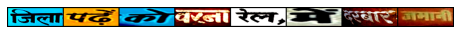

['शर्ागार', 'पसांद', 'भी', 'चर्थ्', 'र्व्ण', 'भी', 'सं्टरल', 'लोबा']
('शस्त्रागार', 'पसांद', 'श्री', 'स्वास्थ्य', 'स्वर्ण', 'श्री', 'सेंट्रल', 'मोबा')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


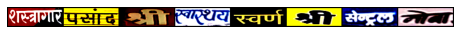

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['रग', 'रून', 'पर', 'दमने', 'घर', 'जर', 'व', 'भिलओ']
('दुर्गा', 'रेल', 'पर', 'बंगले', 'घर', 'जय', 'वॅा', 'मिटाओ')


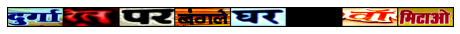

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['पर', 'आपक', 'दरत', 'इंाररसी', 'देर', 'घुी', 'कपया', 'इारसी']
('पेय', 'आपका', 'दांतों', 'इटारसी', 'के', 'पुरानी', 'कृपया', 'इटारसी')


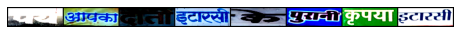

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['सुरा', 'अनाज', 'परिदण', 'एरं', 'अधनी', 'शहर', 'चेशटर', 'का']
('सुरक्षा', 'अनाज', 'प्रशिक्षण', 'एवं', 'अंथोनी', 'शहर', 'वेस्ट', 'कक्षा')


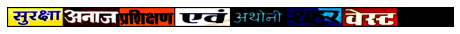

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['यही', 'बंगला', 'कपी', 'अपनी', 'सर्ताह', 'जील', 'एम', 'इधररे']
('यहाँ', 'बंगला', 'कॉपी', 'अपनी', 'सप्ताह', 'जीवन', 'एम', 'इटारसी')


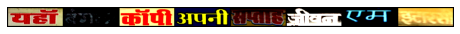

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['टिकिट', 'मुूरईंर', 'म्य', 'याभी', 'परिचम', 'नया', 'ती', 'इलहवाद']
('टिकट', 'मुस्कुराईए', 'मध्य', 'यात्री', 'पश्चिम', 'नया', 'वी', 'इलाहबाद')


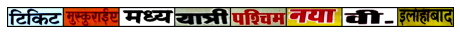

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['रेे', 'खेच्पता', 'राम', 'बाज', 'धूनियन', 'परिलक', 'कपी', 'रं']
('रेलवे', 'स्वच्छता', 'राम', 'बाजू', 'यूनियन', 'परिचालक', 'कॉपी', 'एवं')


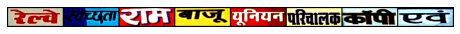

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['स्व््', 'करते', 'कई', 'धर्ावास', 'शाभ', 'फोई', 'रेल', 'दीवान']
('स्वच्छ', 'करते', 'कार्ड', 'छात्रावास', 'लाफ', 'फोड़े', 'रेल', 'दीवान')


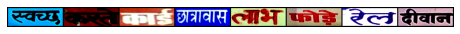

ल---------्््््््यय------- => ल्य                 , gt: लक्ष्य              
भो--------------ाल-------- => भोाल                , gt: भोपाल               
विि-----------ाा-न-------- => विान                , gt: विज्ञान             
रं---------ल-------------- => रंल                 , gt: रेल                 
आर-------------िििि------- => आरि                 , gt: आदि                 
हह--------लल-------------- => हल                  , gt: हॉल                 
धा-----------म------------ => धाम                 , gt: धाम                 
भा--------रर-----तत------- => भारत                , gt: भारत                
Test Loss: 0.232890, Accuray: 0.778848 Average BLEU 0.86270986727302


tensor(0.2329, device='cuda:0')

In [ ]:
def imshow(img, batch_size):
    npimg = img.numpy()
    plt.figure(figsize=(batch_size, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch_images(images,labels,gt_labels,batch_size):
    img = torchvision.utils.make_grid(images)
    print(labels)
    print(gt_labels)
    imshow(img, batch_size)

def test(net, data_loader, criterion, max_iter=1000, display_batches = 10):
    print('Start Testing')
    for p in crnn.parameters():
        p.requires_grad = False
    net.eval();val_iter = iter(data_loader)
    i = 0;n_correct = 0
    loss_avg = averager()

    max_iter = min(max_iter, len(data_loader))

    avg_bleu = 0.0;size = 0
    correct_acc = 0.0;size_acc = 0

    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        loadData(text, t)
        loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target in zip(sim_preds, cpu_texts):
            correct_acc += len(set(pred) & set(target))
            size_acc += min(len(target),len(pred))
            # size_acc += (len(target) + len(pred))/2
            if len(pred) >1 and len(target) >1: 
                avg_bleu += bleu(pred, target)*(len(target))
                size += len(target)

        if i < display_batches:
            show_batch_images(cpu_images,sim_preds,cpu_texts,batch_size)
    
    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:settings.test_batch_size]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))
    accuracy = correct_acc/size_acc;avg_bleu = avg_bleu/size
    print('Test Loss: %f, Accuray: %f Average BLEU' % (loss_avg.val(), accuracy),avg_bleu)
    return loss_avg.val()

test(crnn, test_loader, criterion)

# RESULTS

**TRAINING Phase 1**

**First Set of Training with Adadelta, batch_size = 128**

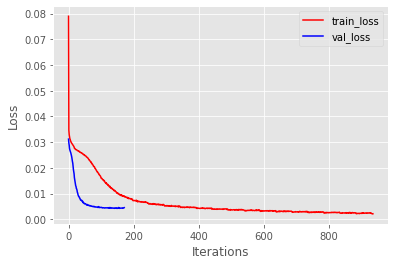

### Testing (Text Recognition) on real dataset

Start Testing


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['समम्ी', 'से', 'नव', 'नागपर', 'का', 'करता', 'पफनीचर', 'यह']
('समस्तीपुर', 'से', 'नव', 'नागपुर', 'कार्य', 'करता', 'फर्नीचर', 'यह')


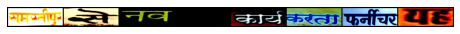

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['सफाई', 'मपड़ल', 'पिी', 'हई', 'बचन', 'का', 'पकि्वम', 'अधिनह']
('सफाई', 'मण्डल', 'पावनी', 'से', 'बचाओ', 'का', 'पश्चिम', 'अभिनन्दन')


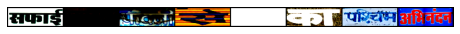

['तगर', 'बुनयानी', 'इंरसी', 'हाल', 'सान', 'पीन', 'लोको', 'सोीज्य']
('नगर', 'बुनयादी', 'इटारसी', 'हॉल', 'सोनी', 'पीने', 'लोको', 'सौजन्य')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


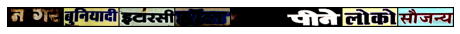

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['का', 'कालेत', 'आति', 'बेटी', 'भी', 'दिराग', 'कजलव', 'इसरी']
('का', 'कालोनी', 'शांति', 'बेटी', 'श्री', 'दिव्यांग', 'कंजलोचन', 'इटारसी')


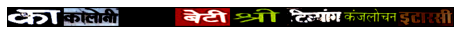

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['नासरे', 'नम', 'निकतन', 'रेल', 'री', 'सूदेशन', 'की', 'कायपालन']
('नासरे', 'नमः', 'निकेतन', 'रेल', 'पश्चिम', 'स्टेशन', 'की', 'कार्यपालन')


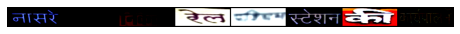

['पल', 'ऐट', 'भईई', 'देशह', 'लो', 'एव्', 'संदर', 'रंे']
('उपलब्ध', 'रेल', 'भाई', 'स्टेशन', 'प्रो', 'एवं', 'सेंटर', 'स्टे')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


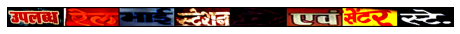

['इटारी', 'पातका', 'मिकती', 'कर', 'संध', 'मुनाफा', 'मदिदर', 'उनकी']
('इटारसी', 'पालिका', 'निक्की', 'करें', 'संघ', 'मुनाफा', 'मन्दिर', 'सबकी')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


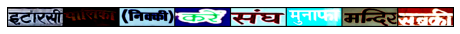

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['क', 'जकिी', 'तिशव', 'बेटी', 'भी', 'पर', 'सेवशन', 'पीने']
('के', 'जावेगी', 'विश्व', 'बेटी', 'सी', 'पर', 'सेक्शन', 'पीने')


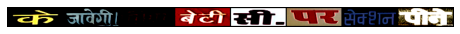

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['परिसर', 'एव्', 'आदि', 'वक', 'तमी', 'की', 'कमरे', 'आार']
('परिसर', 'एवं', 'आदि', 'के', 'वर्मा', 'की', 'कैमरे', 'मार्ट')


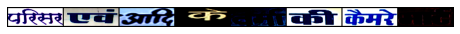

है------------------------ => है                  , gt: है                  
शा-----------दद----ीीी---- => शादी                , gt: शादी                
पर---िििव---ााल----क------ => परिवालक             , gt: परिचालक             
भर--------र--तत----------- => भररत                , gt: भारतीय              
का---------लल----सस------- => कालस                , gt: कॉल्स               
झु-----मम----ाननन----ाा--- => झुमाना              , gt: जुर्माना            
बं-------दद------ीी------- => बंदी                , gt: बैटरी               
मे-------ध----नन----ाा---- => मेधना               , gt: मेघना               
Test Loss: 0.234756, Accuray: 0.205023 Average BLEU 0.8399001540436506


tensor(0.2348, device='cuda:0')

In [ ]:
def imshow(img, batch_size):
    npimg = img.numpy()
    plt.figure(figsize=(batch_size, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch_images(images,labels,gt_labels,batch_size):
    img = torchvision.utils.make_grid(images)
    print(labels)
    print(gt_labels)
    imshow(img, batch_size)

def test(net, data_loader, criterion, max_iter=1000, display_batches = 10):
    print('Start Testing')
    for p in crnn.parameters():
        p.requires_grad = False
    net.eval();val_iter = iter(data_loader)
    i = 0;n_correct = 0
    loss_avg = averager()

    max_iter = min(max_iter, len(data_loader))
    avg_bleu = 0.0;size = 0
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        loadData(text, t)
        loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)

        for pred, target in zip(sim_preds, cpu_texts):
            # print(pred, '\t', target)
            if len(pred) >1 and len(target) >1: 
                avg_bleu += bleu(pred, target)*(len(target))
                size += len(target)
            if pred == target:
                n_correct += 1

        if i < display_batches:
            show_batch_images(cpu_images,sim_preds,cpu_texts,batch_size)
    
    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:settings.test_batch_size]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))
    accuracy = n_correct / float(max_iter * batch_size);avg_bleu /= size
    print('Test Loss: %f, Accuray: %f Average BLEU' % (loss_avg.val(), accuracy),avg_bleu)
    return loss_avg.val()

test(crnn, test_loader, criterion)